Q1  Q2  L1  L2  T   Throughput  Turnaround  Waiting  Response
 5  10  20  20  25  0.011       282.7       21.2    3.2
 5  10  20  20  50  0.013       404.2       26.4    2.7
 5  10  20  20  75  0.010       299.9       24.0    1.0
 5  10  20  30  25  0.014       327.7       33.4    5.9
 5  10  20  30  50  0.012       345.8       30.8    6.9
 5  10  20  30  75  0.012       241.6       35.2    4.9
 5  10  20  40  25  0.012       211.4       42.8    6.8
 5  10  20  40  50  0.012       255.1       43.2    5.4
 5  10  20  40  75  0.011       218.3       41.5    8.8
 5  10  30  20  25  0.010       293.6       32.5    2.4
 5  10  30  20  50  0.011       397.0       35.2    0.7
 5  10  30  20  75  0.011       424.6       33.8    2.7
 5  10  30  30  25  0.011       249.2       44.0    3.2
 5  10  30  30  50  0.011       371.2       40.8    4.9
 5  10  30  30  75  0.012       406.4       44.7    2.5
 5  10  30  40  25  0.013       263.0       51.8    8.1
 5  10  30  40  50  0.013       216.4     

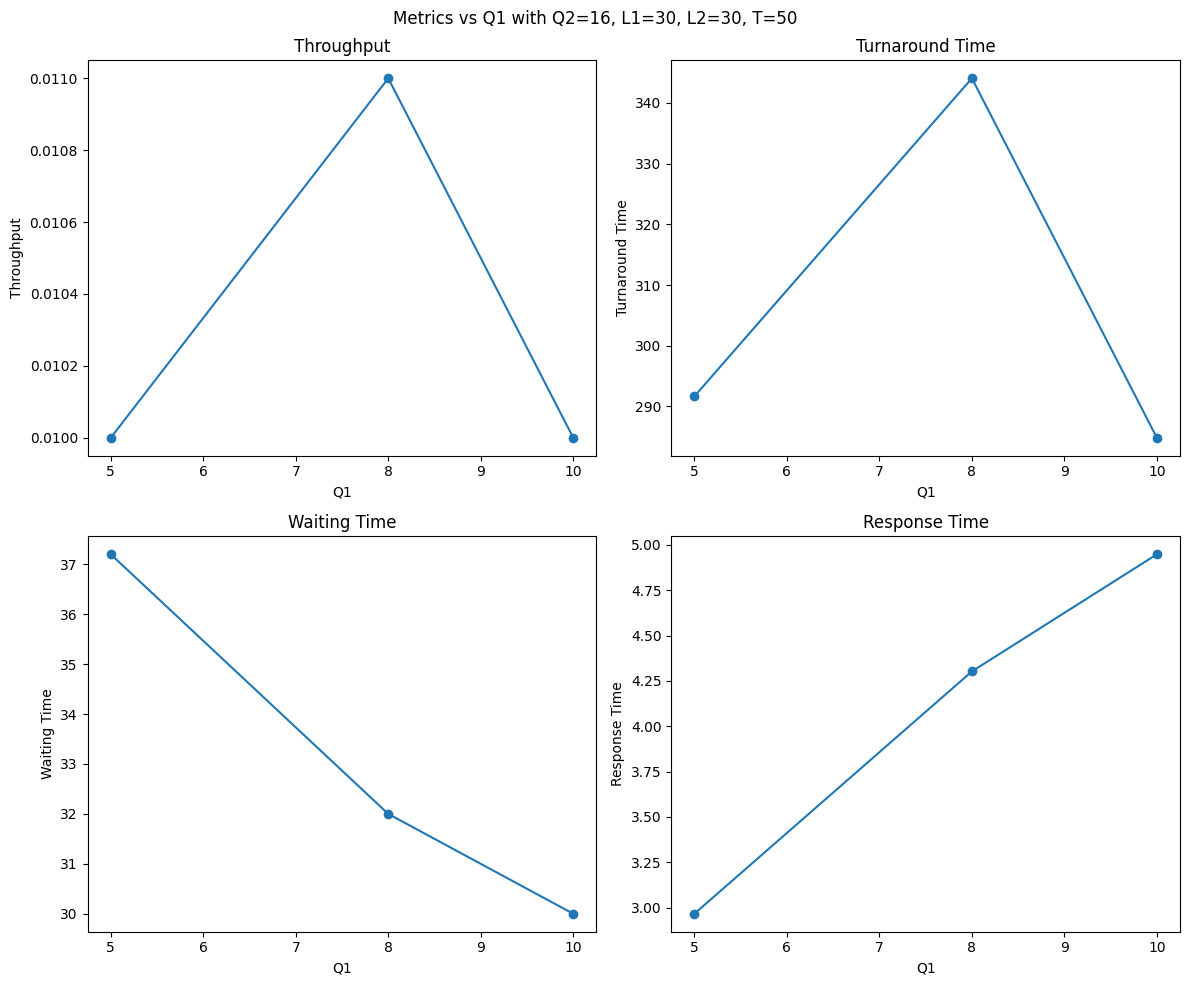

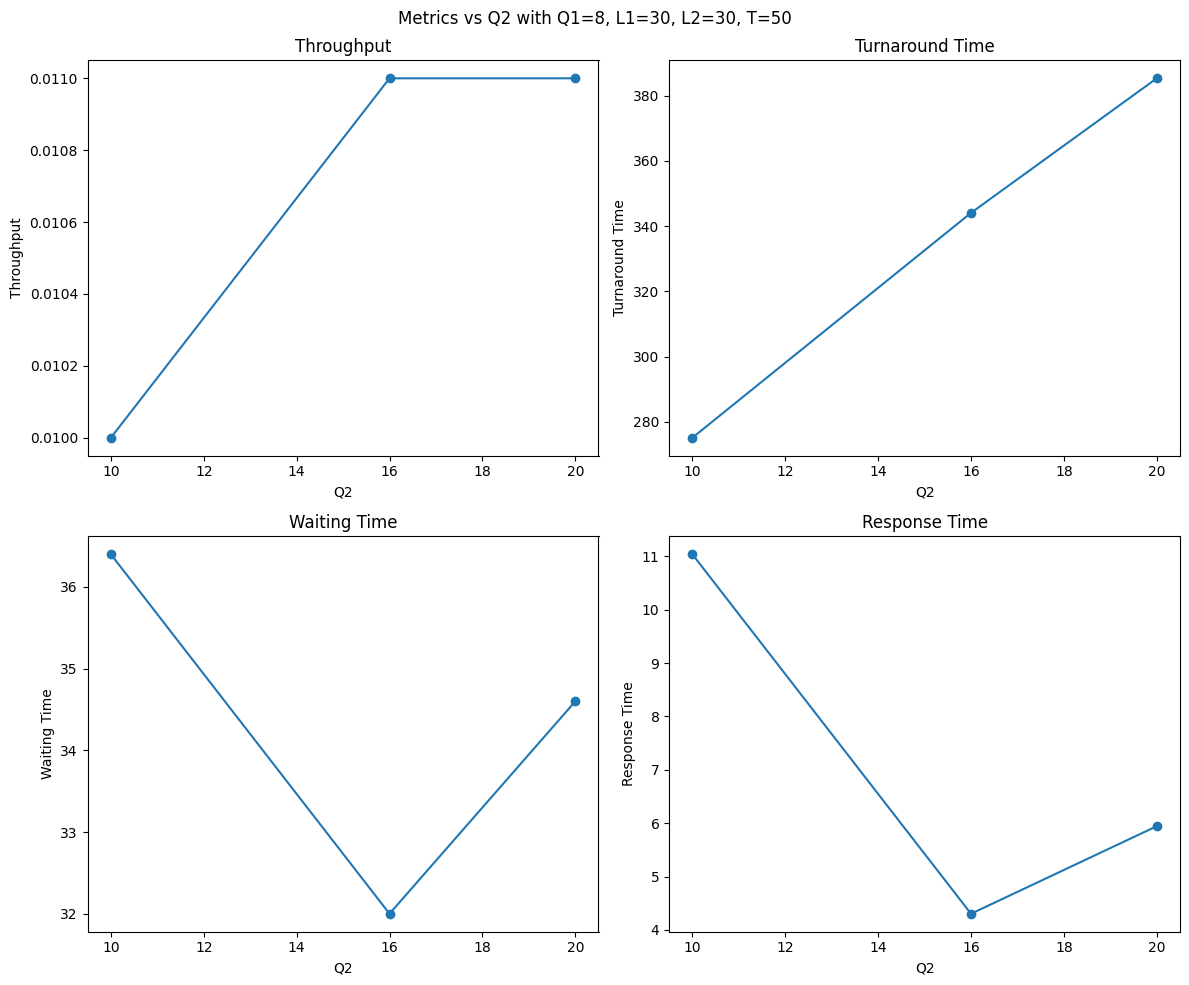

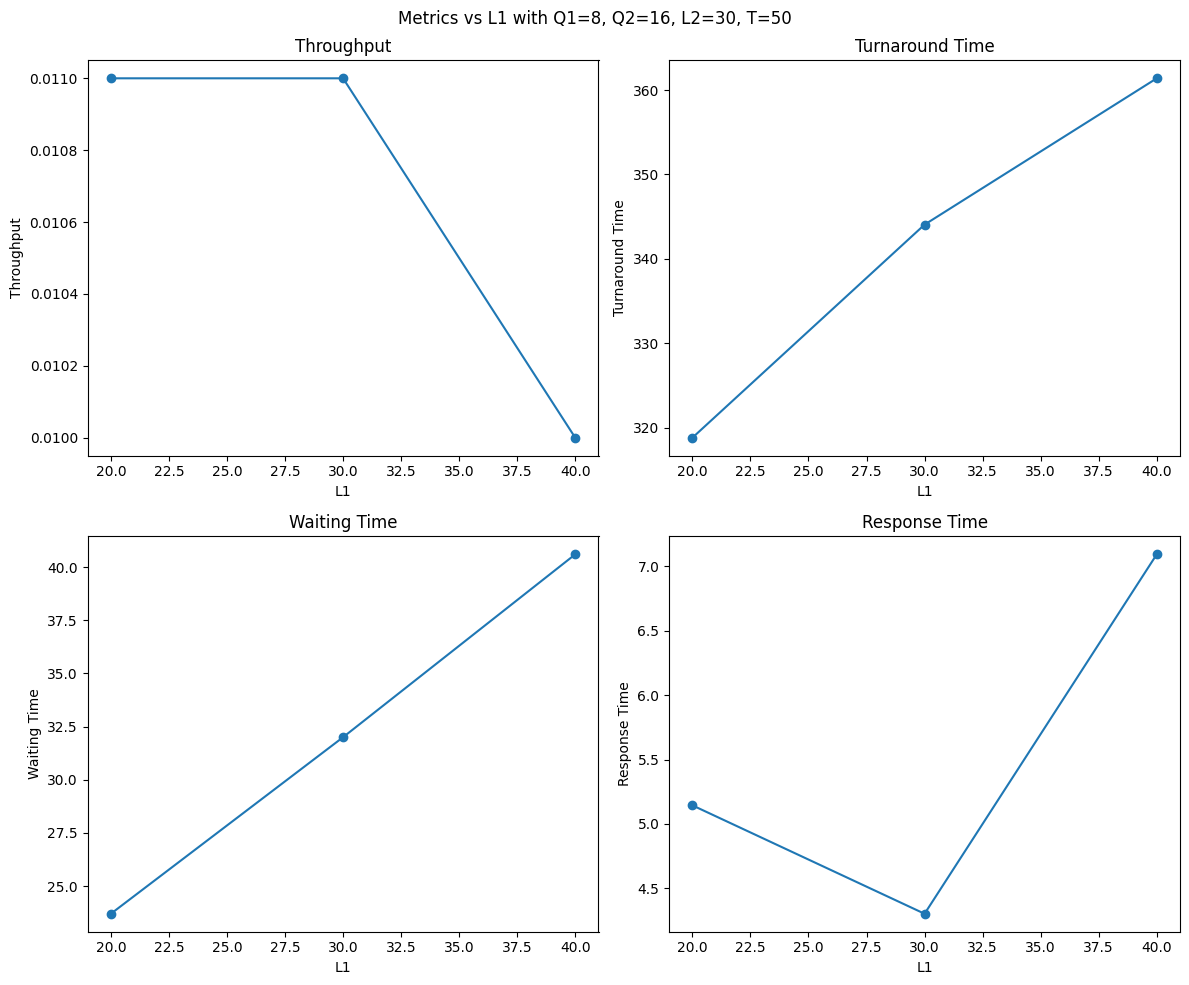

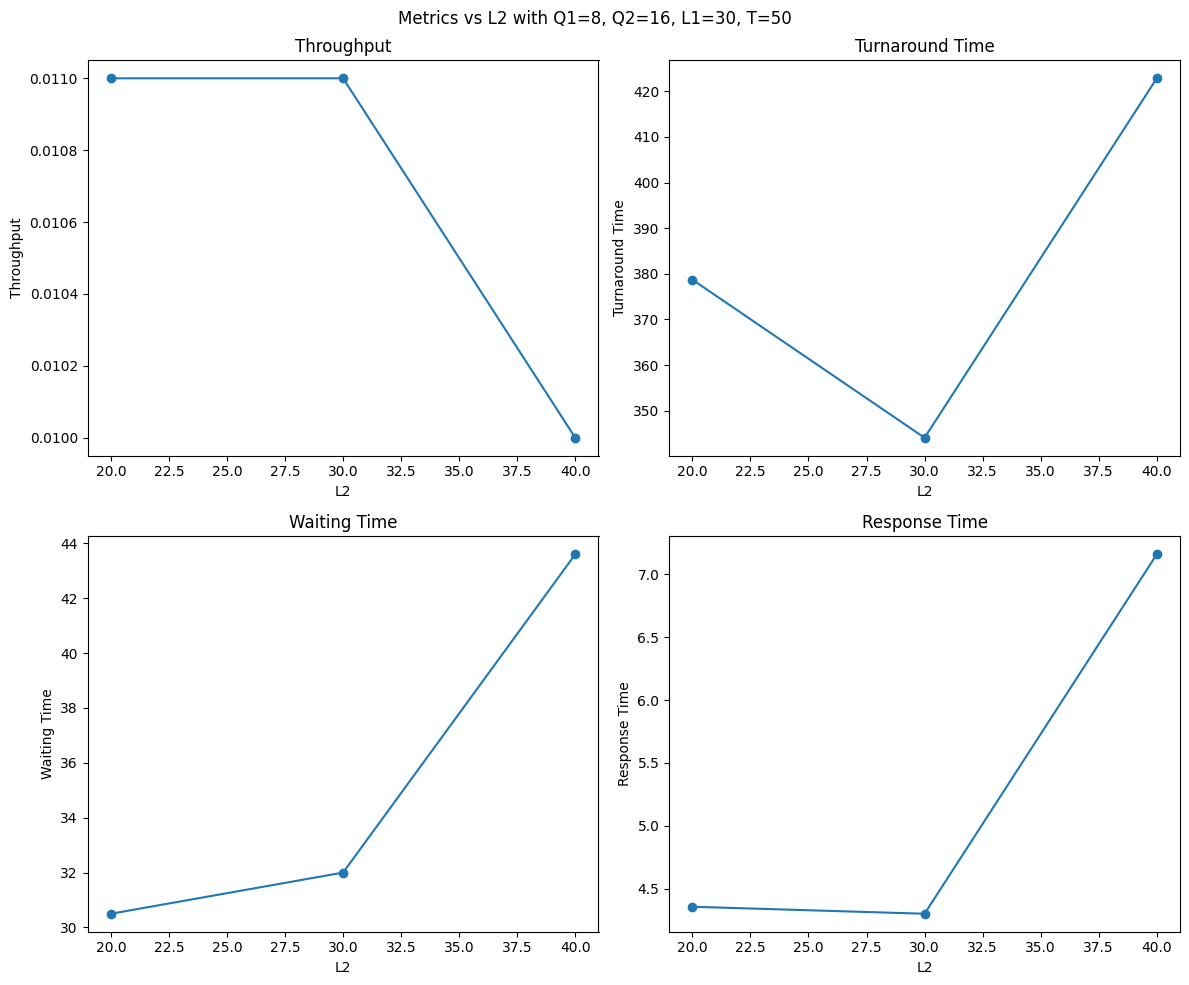

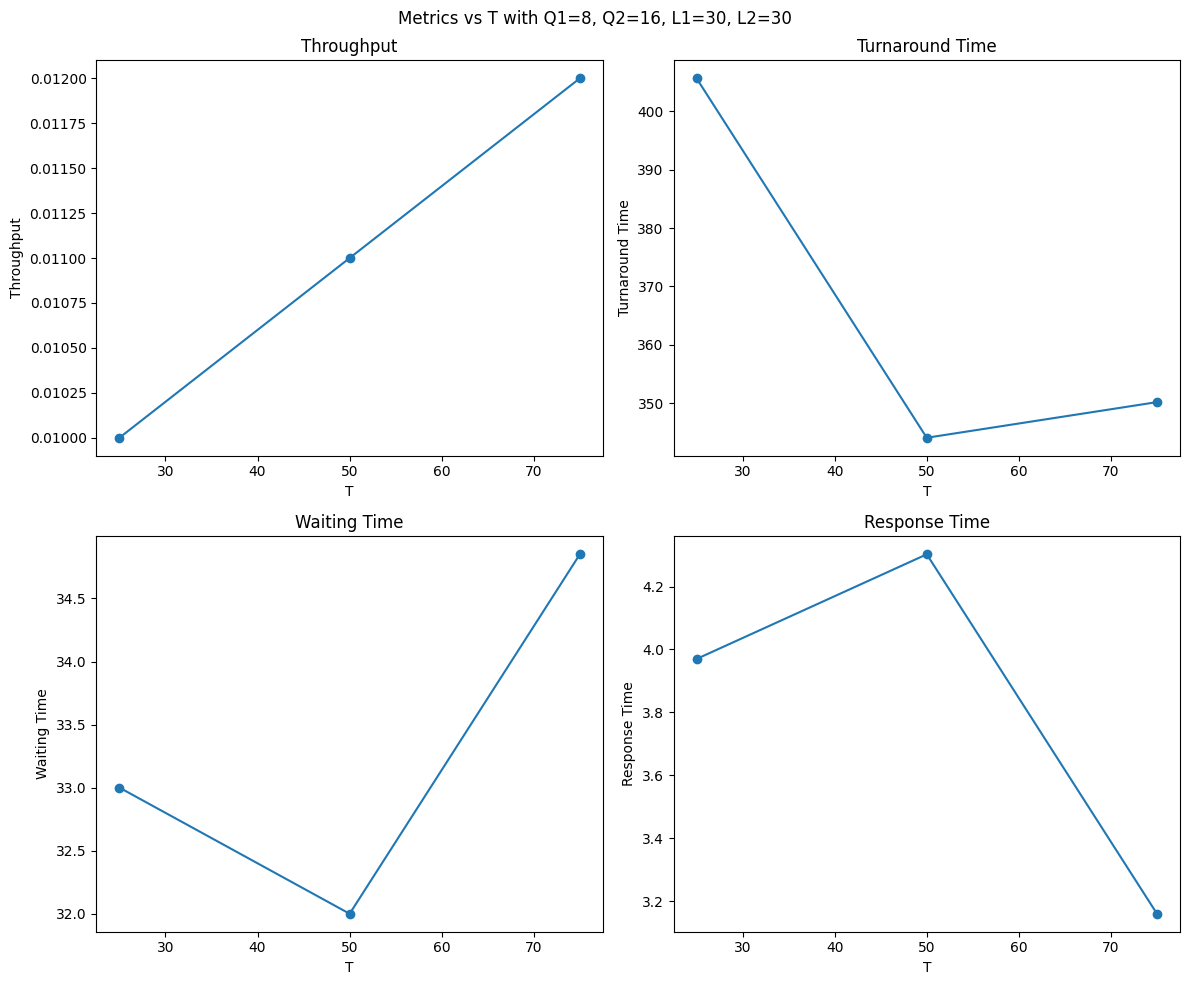

In [2]:
import random
import heapq
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

class Process:
    def __init__(self, pid, arrival_time, burst_time):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.remaining_time = burst_time
        self.start_time = None
        self.completion_time = None
        self.waiting_time = 0
        self.response_time = None
        self.queue_level = 0

class MLFQSimulator:
    def __init__(self, Q1, Q2, L1, L2, T, total_time=100):
        self.Q1 = Q1
        self.Q2 = Q2
        self.L1 = L1
        self.L2 = L2
        self.T = T  # Percentage of Q2 time for SJF (0-100)
        self.total_time = total_time
        self.queues = [deque(), deque(), deque()]  # Q0, Q1, Q2
        self.time = 0
        self.event_queue = []
        self.cpu_free = True
        self.time_spent = [0, 0, 0]  # Time spent in Q0, Q1, Q2
        self.current_process = None
        self.q2_sjf_time = 0  # Track SJF time in Q2

    def simulate(self, processes):
        for p in processes:
            heapq.heappush(self.event_queue, (p.arrival_time, 'arrival', p))

        while self.event_queue and self.time < self.total_time:
            time, event_type, process = heapq.heappop(self.event_queue)
            self.time = time

            if event_type == 'arrival':
                self.queues[0].append(process)
                if self.cpu_free:
                    self.schedule()
            elif event_type in ['quantum_expire', 'complete']:
                if event_type == 'complete':
                    process.completion_time = self.time
                elif process.remaining_time > 0:
                    process.queue_level += 1
                    if process.queue_level < 3:
                        self.queues[process.queue_level].append(process)
                    elif process.queue_level == 3:
                        self.queues[2].append(process)
                self.cpu_free = True
                self.current_process = None
                self.schedule()

    def schedule(self):
        if not self.cpu_free:
            return

        process = None
        queue_idx = None
        quantum = 0

        if self.time_spent[0] < self.L1 and self.queues[0]:
            queue_idx = 0
            quantum = self.Q1
        elif self.time_spent[1] < self.L2 and self.queues[1]:
            queue_idx = 1
            quantum = self.Q2
        elif self.queues[2]:
            queue_idx = 2
            q2_total_time = self.total_time - self.L1 - self.L2
            if self.q2_sjf_time < (self.T / 100) * q2_total_time:
                # SJF in Q2
                process = min(self.queues[2], key=lambda x: x.remaining_time)
            else:
                # FCFS in Q2
                process = self.queues[2][0]
            quantum = float('inf')
        else:
            return

        if queue_idx is not None:
            self.cpu_free = False
            if queue_idx == 2:
                self.queues[2].remove(process)
            else:
                process = self.queues[queue_idx].popleft()

            self.current_process = process

            if process.start_time is None:
                process.start_time = self.time
                process.response_time = self.time - process.arrival_time

            exec_time = min(quantum, process.remaining_time)

            if queue_idx < 2:
                if self.time_spent[queue_idx] + exec_time > [self.L1, self.L2][queue_idx]:
                    exec_time = [self.L1, self.L2][queue_idx] - self.time_spent[queue_idx]

            process.remaining_time -= exec_time
            self.time_spent[queue_idx] += exec_time

            if queue_idx == 2 and self.q2_sjf_time < (self.T / 100) * (self.total_time - self.L1 - self.L2):
                self.q2_sjf_time += exec_time

            for q in self.queues:
                for p in q:
                    if p != process and p.arrival_time <= self.time:
                        p.waiting_time += exec_time

            next_time = self.time + exec_time
            if process.remaining_time <= 0:
                heapq.heappush(self.event_queue, (next_time, 'complete', process))
            else:
                heapq.heappush(self.event_queue, (next_time, 'quantum_expire', process))

    def calculate_metrics(self, processes):
        completed = [p for p in processes if p.completion_time is not None]
        if not completed:
            return 0, 0, 0, 0
        throughput = len(completed) / self.total_time
        turnaround = sum(p.completion_time - p.arrival_time for p in completed) / len(completed)
        waiting = sum(p.waiting_time for p in completed) / len(completed)
        response = sum(p.response_time for p in completed) / len(completed)
        return throughput, turnaround, waiting, response

def run_simulations(N, M, Q1_vals, Q2_vals, L1_vals, L2_vals, T_vals, num_runs=10):
    results = {}
    for Q1 in Q1_vals:
        for Q2 in Q2_vals:
            for L1 in L1_vals:
                for L2 in L2_vals:
                    for T in T_vals:
                        if L1 + L2 >= 100:
                            continue
                        key = (Q1, Q2, L1, L2, T)
                        throughput_list, turnaround_list, waiting_list, response_list = [], [], [], []
                        for _ in range(num_runs):
                            processes = [Process(i, random.uniform(0, M), random.randint(10, 1000))
                                         for i in range(N)]
                            simulator = MLFQSimulator(Q1, Q2, L1, L2, T)
                            simulator.simulate(processes)
                            metrics = simulator.calculate_metrics(processes)
                            throughput_list.append(metrics[0])
                            turnaround_list.append(metrics[1])
                            waiting_list.append(metrics[2])
                            response_list.append(metrics[3])
                        results[key] = (
                            np.mean(throughput_list),
                            np.mean(turnaround_list),
                            np.mean(waiting_list),
                            np.mean(response_list)
                        )
    return results

def plot_results(results, Q1_vals, Q2_vals, L1_vals, L2_vals, T_vals):
    params = {'Q1': Q1_vals, 'Q2': Q2_vals, 'L1': L1_vals, 'L2': L2_vals, 'T': T_vals}
    fixed = {k: v[len(v)//2] for k, v in params.items()}  # Fix to middle value

    for param_to_vary in params.keys():
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'Metrics vs {param_to_vary} with ' +
                     ', '.join(f"{k}={fixed[k]}" for k in params if k != param_to_vary))

        for i, metric in enumerate(['Throughput', 'Turnaround Time', 'Waiting Time', 'Response Time']):
            data = []
            for val in params[param_to_vary]:
                key = tuple(val if param_to_vary == p else fixed[p] for p in ['Q1', 'Q2', 'L1', 'L2', 'T'])
                data.append(results[key][i])
            ax = axs[i//2, i%2]
            ax.plot(params[param_to_vary], data, marker='o')
            ax.set_title(metric)
            ax.set_xlabel(param_to_vary)
            ax.set_ylabel(metric)

        plt.tight_layout()
        plt.show()

# Example usage
N, M = 1000, 100
Q1_vals = [5, 8, 10]
Q2_vals = [10, 16, 20]
L1_vals = [20, 30, 40]
L2_vals = [20, 30, 40]
T_vals = [25, 50, 75]
results = run_simulations(N, M, Q1_vals, Q2_vals, L1_vals, L2_vals, T_vals)

# Print results
print("Q1  Q2  L1  L2  T   Throughput  Turnaround  Waiting  Response")
for (Q1, Q2, L1, L2, T), (t, ta, w, r) in results.items():
    print(f"{Q1:2d}  {Q2:2d}  {L1:2d}  {L2:2d}  {T:2d}  {t:.3f}       {ta:.1f}       {w:.1f}    {r:.1f}")

# Plot graphs
plot_results(results, Q1_vals, Q2_vals, L1_vals, L2_vals, T_vals)
